# Tripsacum seedhead tutorial (For Google Colaboratory)
### About this jupyter notebook

This notebook contains the code for getting the following phenotypes from tripsacum seed head images.
- length of entire seed head
- length of female flower part
- length of male flower part
- color phenotypes of each part
- estimate of seed count 

Project context: This is a New Roots for Restoration project that is being run both at Kansas University (KU) Field Research Site and the Danforth Field Research Site. All seed heads were removed and imaged once they were determined to be mature, and the imaging happened with cell phones. In the KU branch of the experiment, seed heads were imaged in a growth chamber (for better and more consistent lighting conditions compared to in the field) and there are usually 3 seed heads per image. Seed heads within a single image all come from the same plant.

Made by Haley Schuhl. Updated May 2025. 

In [ ]:
# Install PlantCV and required dependencies
%pip install "altair>=5" ipympl plantcv

# Give access and mount your Google Drive (need a Google Account)
# Change path to directory you wish output files to be saved to.
from google.colab import drive
drive.mount('/content/gdrive')

# Enable widget feature with matplotlib
from google.colab import output
output.enable_custom_widget_manager()

#View working directory, may need to change path
%pwd

# Section 1: Importing Image and Libraries

In [1]:
# Set the notebook display method
# If widget is not working, then change to inline
%matplotlib widget
# Import libraries
import matplotlib
import numpy as np
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

# Print out the version of PlantCV being used by the Jupyter kernel
pcv.__version__

'4.8.dev21+g88c56188'

## Input/Output variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [2]:
# Input/output options
args = WorkflowInputs(
    images=["./img/seedheads.JPEG"],
    names="image1",
    result="out_data.json",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

# Set debug to the global parameter 
pcv.params.debug = args.debug
# Quite warnings
pcv.params.verbose = False
# Global settings
matplotlib.rcParams["figure.max_open_warning"] = False

In [3]:
# Change display settings
pcv.params.dpi = 100
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 20
pcv.params.text_thickness = 20

## Read the input image

### Google Colaboratory Users:
If you are running this notebook using Google Colaboratory, you will need to use the cell below to complete the tutorial unless you cloned the repository from GitHub to your personal Google Drive account. Once you begin developing your workflow for your data, you can delete this text cell and the code cell below so you avoid any conflicts the next time you use this notebook.

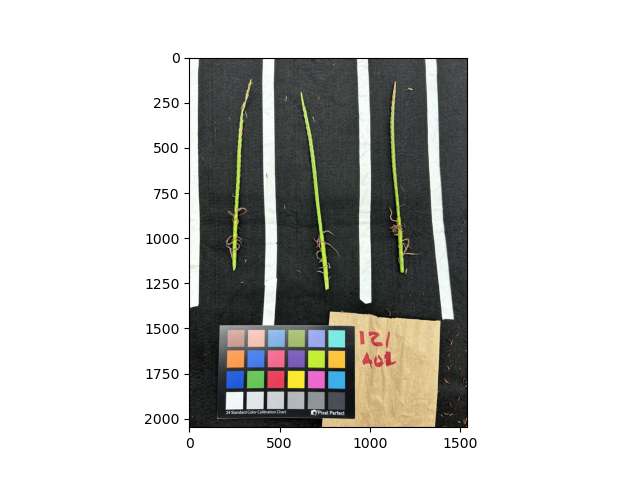

In [4]:
img = pcv.io.open_url(url="https://raw.githubusercontent.com/danforthcenter/plantcv-tutorial-tripsacum-seedhead/main/img/seedheads.JPEG")

### Local system use:
If you have downloaded this notebook or the repository to your local device, then you will need to use the cell below to bring your image into the notebook. Do not run this line if you are navigating through the **tutorial** using Google Colaboratory.

NOTE: *If you are developing your own workflow using this notebook, make sure you remove the code cell above with the URL and uncomment (remove the hashtag [#] to make the code active. This will call the image you defined during the Inputs/Outputs step.*

### Reading images into your environment using *pcv.readimage()*
Inputs:
   * filename = Image file to be read in
   * mode     = How the image will be read into the notebook; either 'native' (default), 'rgb', 'gray', 'csv', or 'envi'

In [5]:
# img, path, filename = pcv.readimage(filename=args.image1)

# Standardize colorspace (correct color) 

Corrects the color of the input image based on the target color matrix using an affine transformation in the RGB space after automatic detection of a color card within the image.

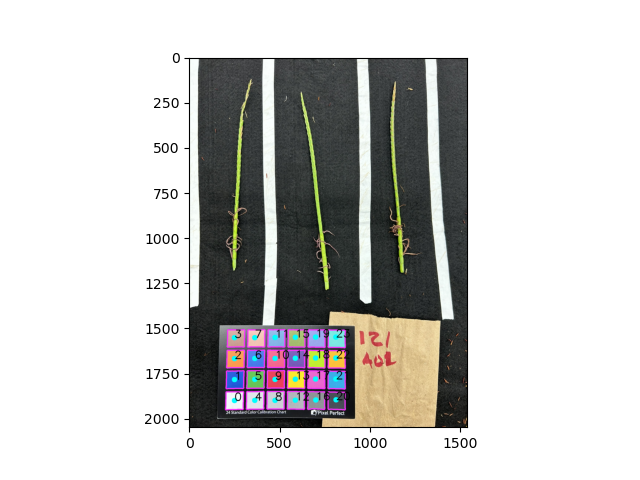

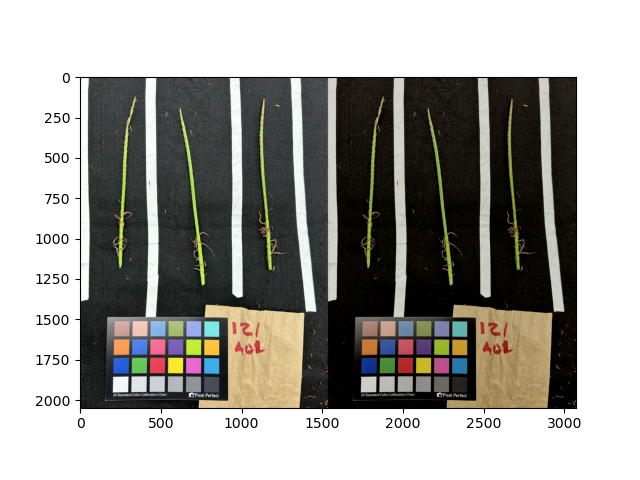

In [6]:
pcv.params.text_size = 2
pcv.params.text_thickness = 4
# Perform color correction 
img = pcv.transform.auto_correct_color(rgb_img=img, radius=15)

## Visualize colorspaces 

The visualization tool converts the color image into HSV, LAB, and CMYK colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

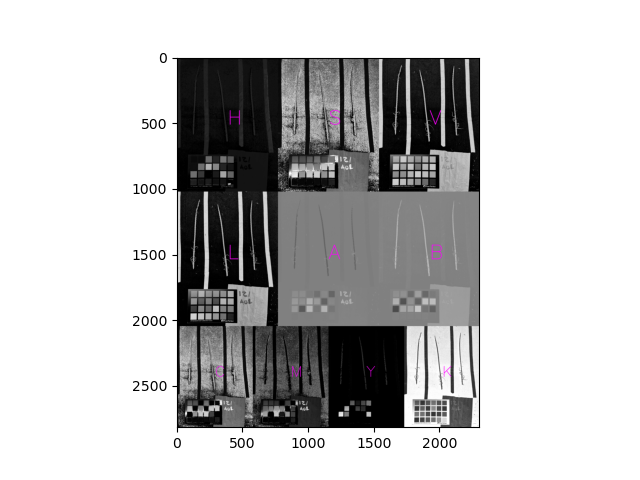

In [7]:
## Visualize all possible colorspaces
pcv.params.text_size = 10
pcv.params.text_thickness = 10
vis = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

## Convert the color image to grayscale
Converts the input color image into the LAB colorspace and returns the B (blue-yellow) channel as a grayscale image.


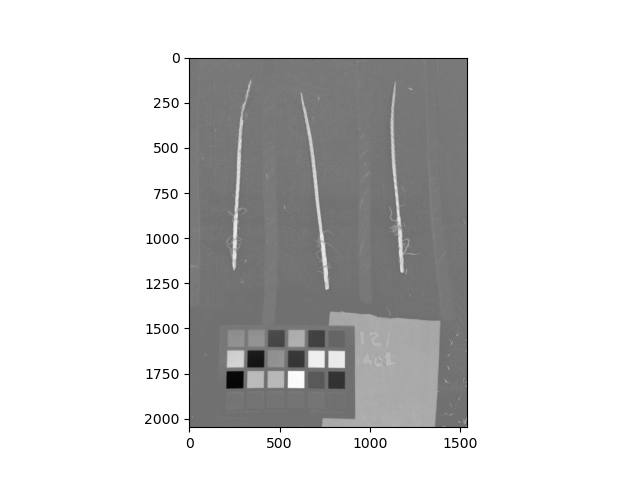

In [8]:
gray = pcv.rgb2gray_lab(rgb_img=img, channel="b")

## Threshold the grayscale image 
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Because the seed-heads are the lighter pixels in this image, use object_type="light" to do a traditional threshold.

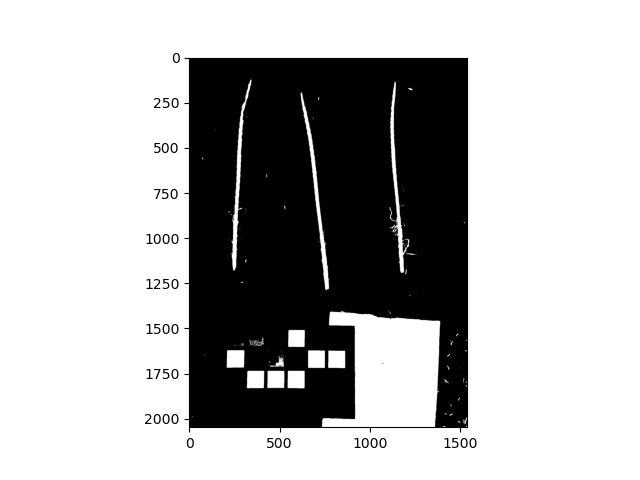

In [9]:
## Roughly segment the whole flower from the background 
total_flower = pcv.threshold.binary(gray_img=gray, threshold=145, object_type="light")

## Remove small background noise
Thresholding mostly labeled plant pixels white but also labeled small regions of the background white. The fill function removes "salt" noise from the background by filtering white regions by size.



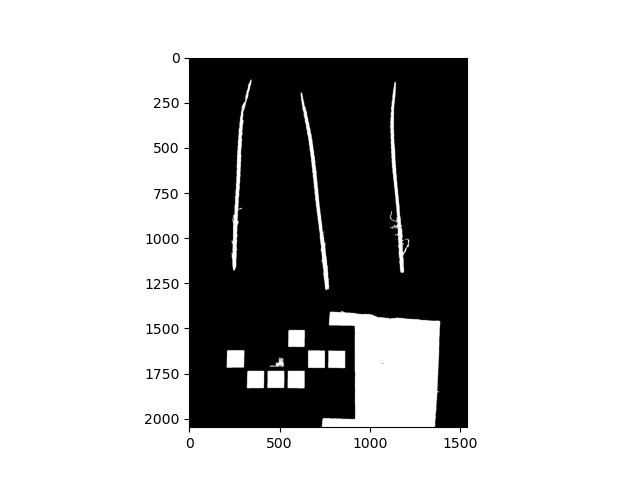

In [10]:
## Fill small objects to clean up the mask
total_flower_filled = pcv.fill(total_flower, size=500)

## Define the region of interest (ROI) to separate seed heads. 
Each ROI will be associated with a seed head later. The ROIs do not need to completely contain an inflorescence but must only overlap one each. 

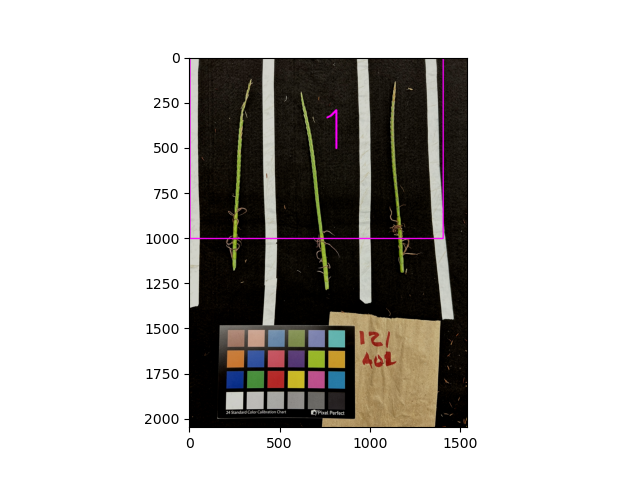

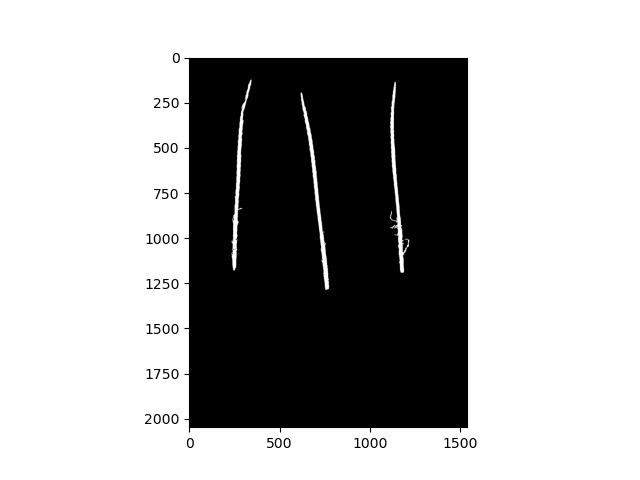

In [11]:
### First use a single ROI to clean the object mask. This will speed up downstream steps 
## Define a region of interest to remove the color card
roi = pcv.roi.rectangle(img=img, x=5, y=5, h=1000, w=1400) 
total_flower_clean = pcv.roi.filter(roi=roi, mask=total_flower_filled, roi_type="partial")


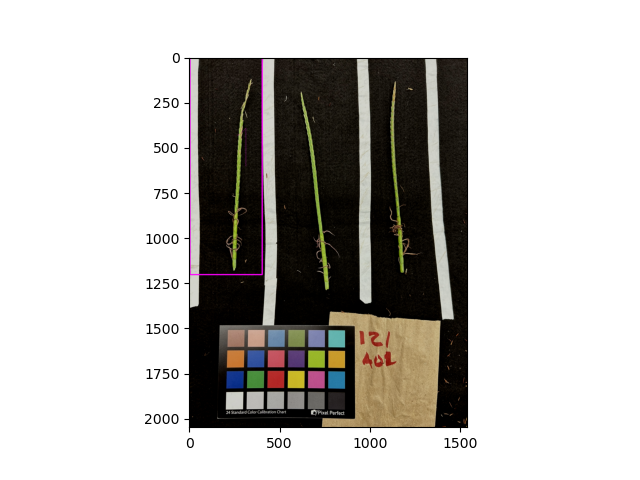

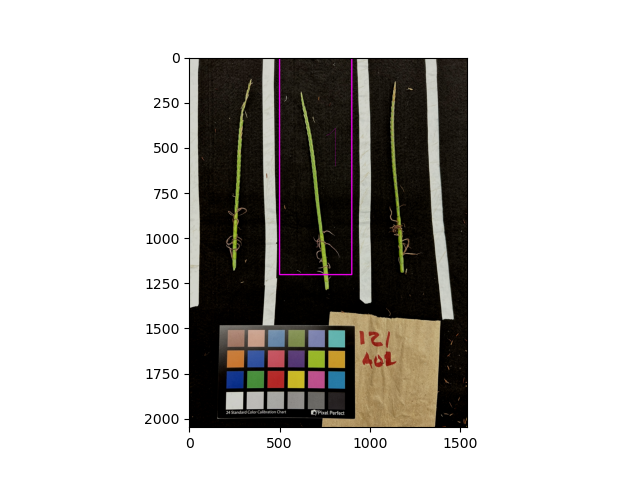

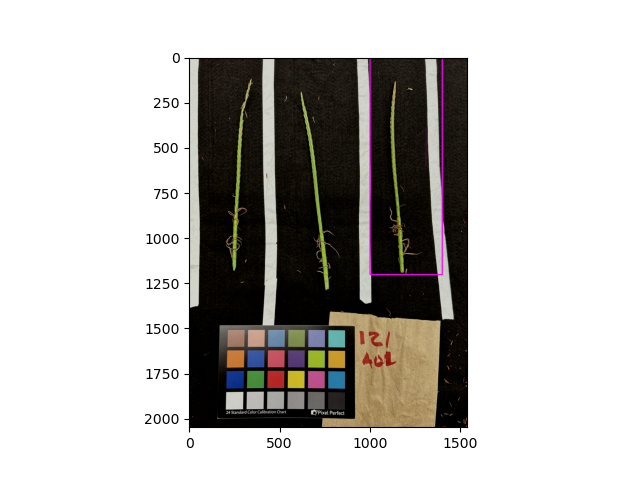

In [12]:
## Make 3 ROIs to separate seed heads (even if mask is broken up into multiple peices) 
pcv.params.text_thickness = 0

start_coords = [5, 500, 1000]
roi_objects = pcv.Objects() 
ref_img = img
for i in range(3):
    roi1 = pcv.roi.rectangle(img=ref_img, x=start_coords[i], y=5, h=1200, w=400)  ## appropriate for KU data
    roi_objects.append(roi1.contours, roi1.hierarchy)


## Create a labeled mask
In order to measure each plant separately, rather than as one object of disconnected blobs, we must create a labeled masked where each plant has a specific pixel value even in the case of disconnected leaves in the binary mask.

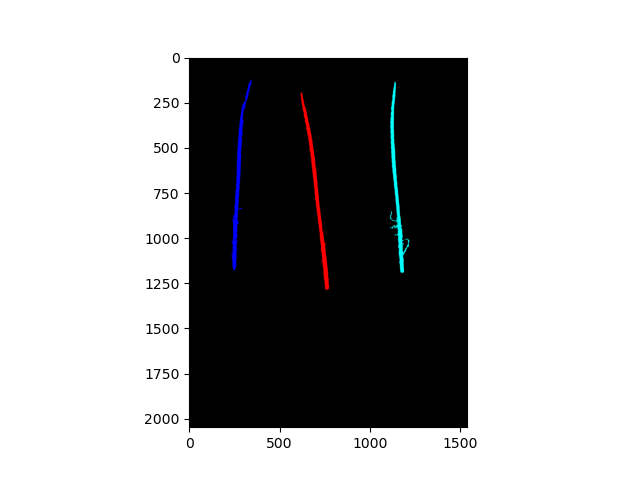

In [13]:
total_label, num_t = pcv.create_labels(mask=total_flower_clean, rois=roi_objects, roi_type="partial")

## Measure each seed-head
Analyze shape and size perameters of each seed-head. Traits are automatically saved to `Outputs`.


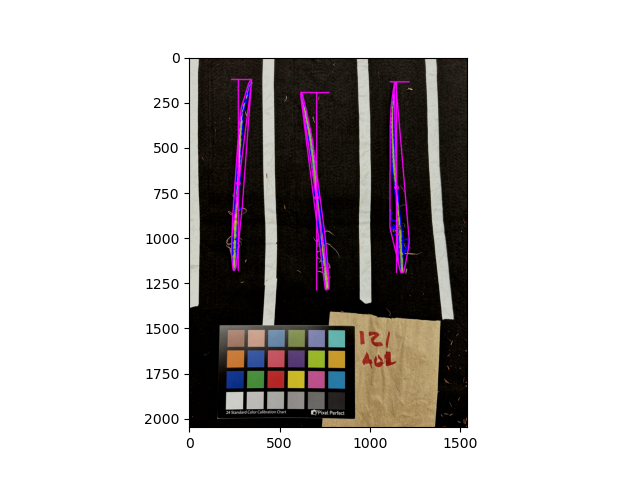

In [14]:
_ = pcv.analyze.size(img=img, labeled_mask=total_label, n_labels=num_t, label="total")


# Segmentation of female part
Separate out the extra bright female part of the flower.


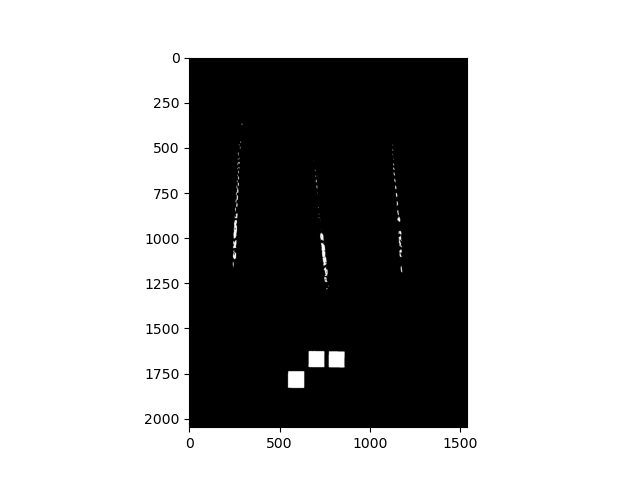

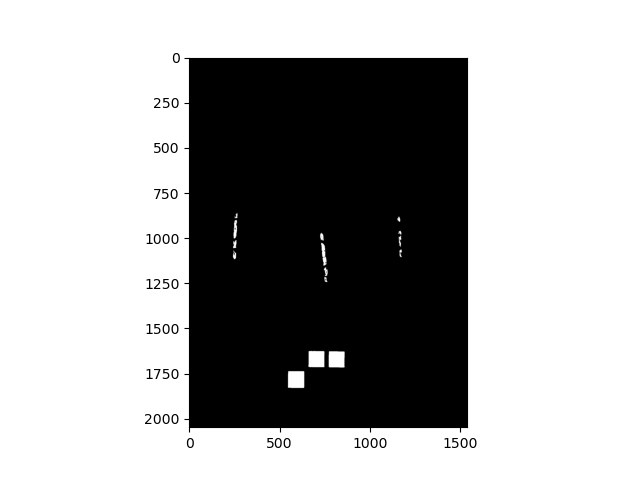

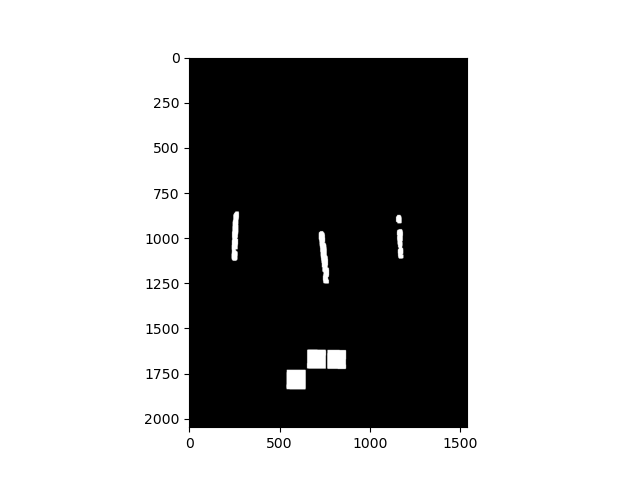

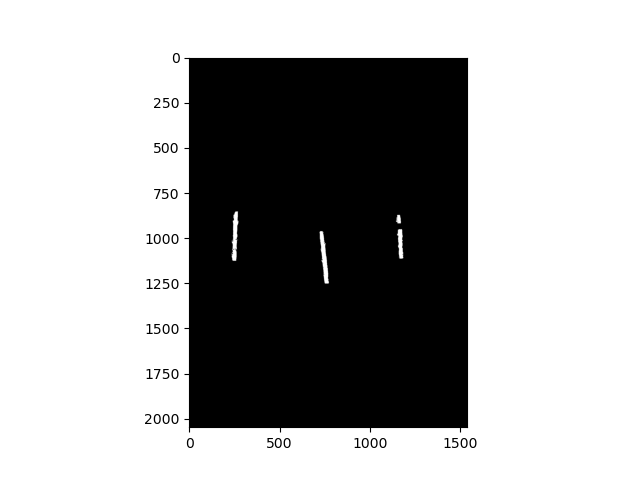

In [15]:
female_flower = pcv.threshold.binary(gray_img=gray, threshold=183, object_type="light")

## Clean up female flower mask by filling in small objects in the mask
female_flower = pcv.fill(female_flower, size=200)
## Dilate to help close the disconnected parts of flower
female_flower = pcv.dilate(female_flower, ksize=5, i=4)
## Trim back the extent of the mask to the same boundaries as the whole seed-head mask
female_flower = pcv.logical_and(bin_img1=female_flower, bin_img2=total_flower_clean)

## Create labeled mask of female flower parts

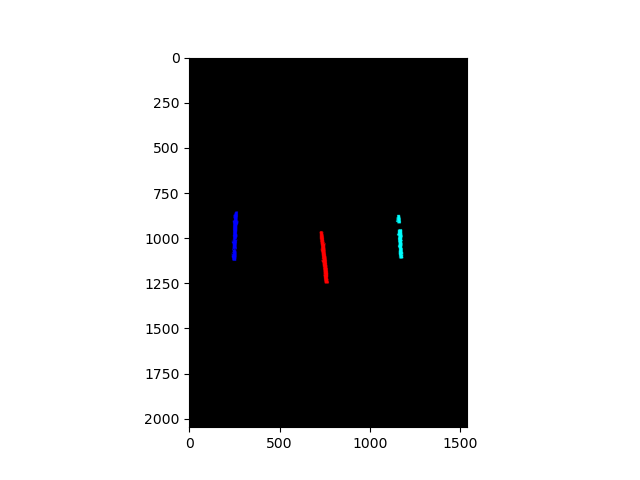

In [16]:
## Analyze color of female part 
female_label, numf = pcv.create_labels(mask=female_flower, rois=roi_objects, roi_type="partial")


## Measure size of each
Analyze shape and size perameters of the female flower part. Note the `label` is updated so the three instances of size measurements are distinguishable from the whole seed head size data. 


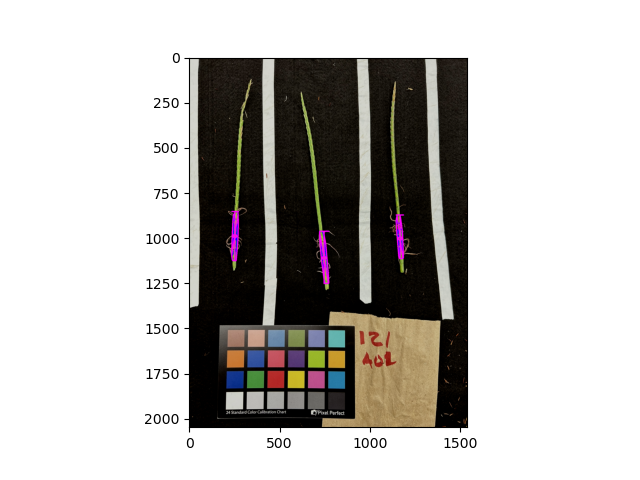

In [17]:
shape_img = pcv.analyze.size(img=img, labeled_mask=female_label, n_labels=numf, label="female")

## Measure color of each
Extract color data of objects and produce a histogram. HSV (Hue, Saturation, Value) and summary statistics about hue are saved for each object. 

In [18]:
color_hist = pcv.analyze.color(rgb_img=img,
                               labeled_mask=female_label,
                               n_labels=numf,
                               colorspaces="HSV",
                               label="female")

alt.FacetChart(...)

# Subtract masks to analyze the male flower part 
Subtract the female portion of the flower to break the inflorescences into parts


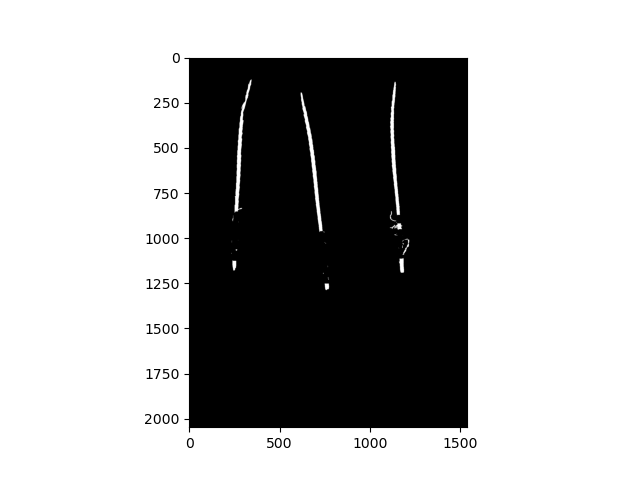

In [19]:
male = total_flower_clean - female_flower
pcv.plot_image(male)


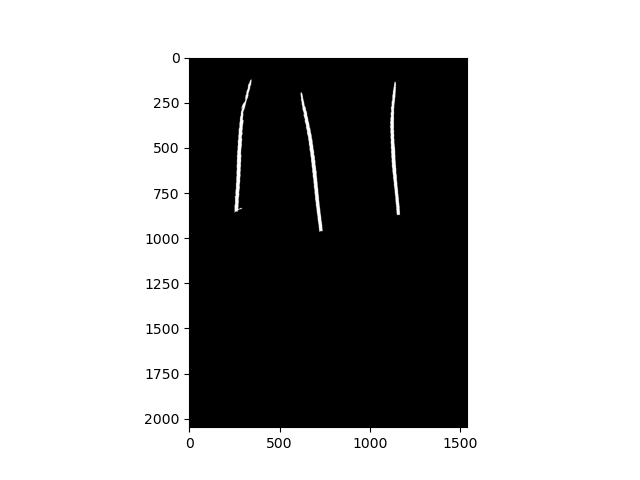

In [20]:
# Clean up male mask 
male = pcv.fill(bin_img=male, size=3500)

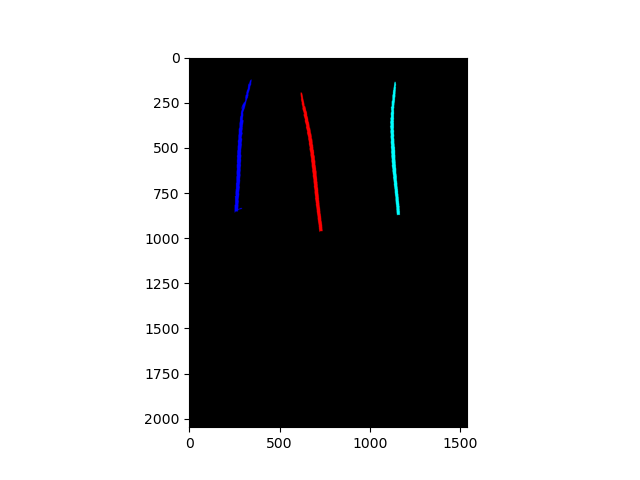

In [21]:
## Create labels (labeled masks) for analysis 
male_label, num = pcv.create_labels(mask=male, rois=roi_objects, roi_type="partial")

## Measure size of each
The `label` once again reflects the plant seed-head part being measured. 

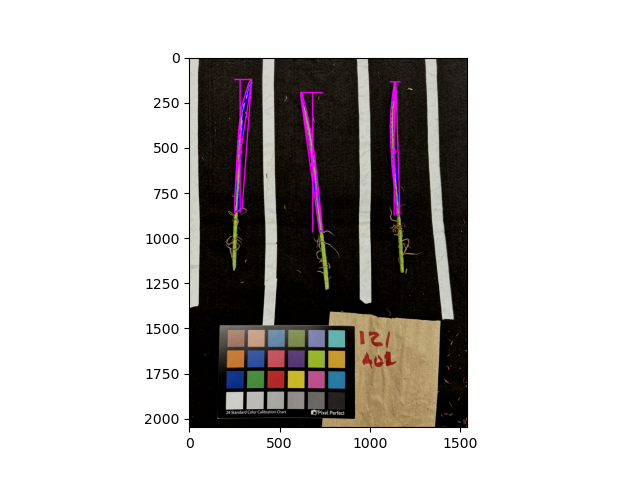

In [22]:
shape_img = pcv.analyze.size(img=img, labeled_mask=male_label, n_labels=num, label="male")


## Measure color of each
The histogram will plot all color data that exists within the `Outputs` data. 

In [23]:
color_hist = pcv.analyze.color(rgb_img=img,
                               labeled_mask=male_label,
                               n_labels=num,
                               colorspaces="HSV",
                               label="male")


alt.FacetChart(...)

# Estimate seed number 

In this case, the number of objects reported from the analyze watershed function is a rough estimation of the number of seeds. The Watershed Segmentation Function is a PlantCV function based on code contributed by Suxing Liu, Arkansas State University for use counting arabidopsis leaves. For more information see https://github.com/lsx1980/Leaf_count.

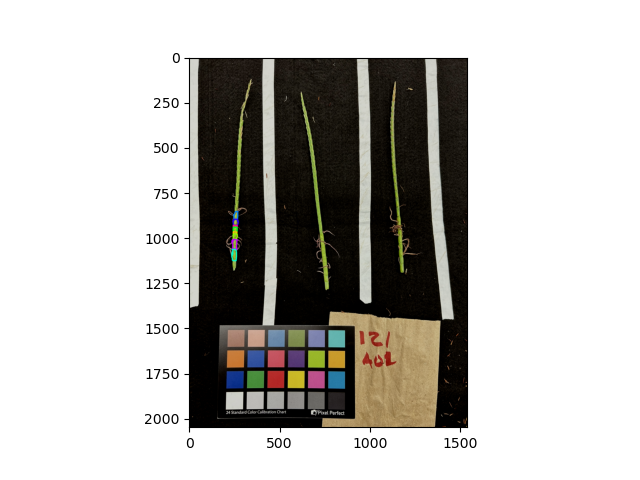

9


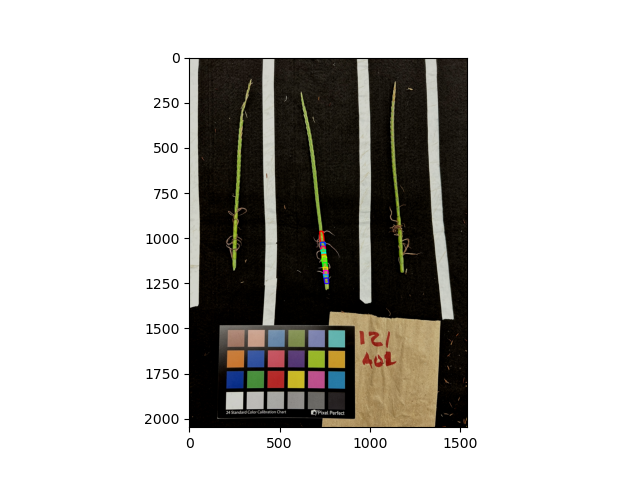

14


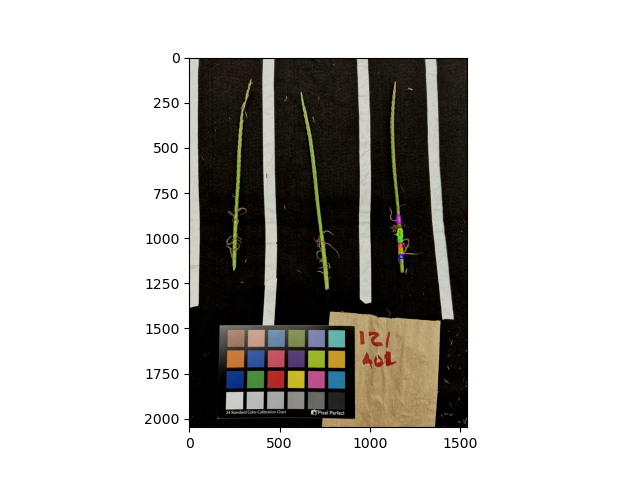

7


In [24]:
# Custom code for printing seed count PER seed-head 

mask_copy = np.copy(female_label)
for i in [1,2,3]:
    ## Subset the mask to get one seed-head per mask 
    submask = np.where(mask_copy == i, 255, 0).astype(np.uint8)
    labels = pcv.watershed_segmentation(rgb_img=img, mask=submask, distance=10, label=None)
    print(len(np.unique(labels)))
    # Save observations to outputs per seed-head
    pcv.outputs.add_observation(sample="female_" + str(i),
                            variable='estimated_seed_count_per_head',
                            trait='watershed seed count',
                            method='plantcv.watershed_segmentation',
                            scale='none', datatype=int,
                            value=len(np.unique(labels)), label="none")


# Save results
During analysis, measurements are stored in the background in the `Outputs` recorder.

This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' using size analysis. Color analysis saves frequency data about pixel values in each of the specified colorspace channels and `hue_circular_mean`, `hue_circular_std`, and `hue_median`. 

Here, results are saved to JSON file, and this allows for database concatenation while running workflows in parallel.

In [26]:
## Save data out to file 

pcv.outputs.save_results(filename=args.result, outformat="json")